In [1]:
import cv2

In [42]:
#读取图片部分代码来自网络
def read_picture(path,n_C):
    import os
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    datas=[]
    x_dirs=os.listdir(path)
    for x_file in x_dirs:
        fpath=os.path.join(path,x_file)
        if n_C == 1 :
            _x=Image.open(fpath).convert("L")
            #plt.imshow(_x,"gray")   #显示图像(只显示最后一张)
        elif n_C == 3:
            _x=Image.open(fpath)
            #plt.imshow(_x)         #显示图像(只显示最后一张)
        else:
            print("错误：图像维数错误")
        n_W=_x.size[1]
        n_H=_x.size[0]
        #若要对图像进行放大缩小，激活（去掉注释）以下函数
        '''
        rat=0.8          #放大/缩小倍数
        n_W=int(rat*n_W)
        n_H=int(rat*n_H)
        _x=_x.resize((n_W,n_H))  #直接给n_W,n_H赋值可将图像变为任意大小
        '''
        datas.append(np.array(_x))
        _x.close()  
    datas=np.array(datas)
    
    m=datas.shape[0]
    datas=datas.reshape((m,n_H,n_W,n_C))
    print(datas.shape)
    
    return datas


In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os


base_dir = 'D:\\food_dataset\\food_dataset'
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation') 
test_dir = os.path.join(base_dir, 'test')

In [54]:
def getDataset(path):
    dset = np.empty([0,320,200,3],dtype = 'float32')
    dset = np.asarray(dset)
    foodlist = ['donuts','egg_tart','hamburger','ice_cream','pizza','steak']
    for i in range(6):
        tmpdir = os.path.join(path,foodlist[i])
        dset = np.concatenate((dset,read_picture(tmpdir,3)),axis = 0)
    
    return dset

In [55]:
import numpy as np
X_train = getDataset(train_dir)

(1000, 320, 200, 3)
(1000, 320, 200, 3)
(1000, 320, 200, 3)
(1000, 320, 200, 3)
(1000, 320, 200, 3)
(1000, 320, 200, 3)


In [56]:
X_train = np.asarray(X_train)

In [57]:
X_train.shape

(6000, 320, 200, 3)

In [58]:
X_validation = getDataset(validation_dir)

(200, 320, 200, 3)
(200, 320, 200, 3)
(200, 320, 200, 3)
(200, 320, 200, 3)
(200, 320, 200, 3)
(200, 320, 200, 3)


In [59]:
X_validation.shape

(1200, 320, 200, 3)

In [60]:
X_test = getDataset(test_dir)

(100, 320, 200, 3)
(100, 320, 200, 3)
(100, 320, 200, 3)
(100, 320, 200, 3)
(100, 320, 200, 3)
(100, 320, 200, 3)


In [61]:
X_test.shape

(600, 320, 200, 3)

In [62]:
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    #以下4行做图像标准化
                    featurewise_center=True, 
                    featurewise_std_normalization=True,
                    samplewise_center=True, 
                    samplewise_std_normalization=True
                    )

In [63]:
train_datagen.fit(X_train)

In [64]:
val_datagen = ImageDataGenerator(rescale = 1./255,
                                #以下4行做图像标准化
                                featurewise_center=True, 
                                featurewise_std_normalization=True,
                                samplewise_center=True, 
                                samplewise_std_normalization=True
                                )

In [65]:
val_datagen.fit(X_validation)

In [66]:
batchsize = 30

In [67]:
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size = (320,200),
                    batch_size = batchsize,
                    )

validation_generator = val_datagen.flow_from_directory(
                    validation_dir,
                    target_size = (320,200),
                    batch_size = batchsize,
                    )



Found 6000 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


In [68]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(320, 200, 3))



conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 50, 128)       0     

In [69]:
from tensorflow.keras import regularizers

In [70]:
from keras import models
from keras import layers
from tensorflow import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
model.add(layers.Dense(6, activation='softmax'))

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 6, 512)        14714688  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dropout (Dropout)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 128)               3932288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 18,655,622
Trainable params: 18,655,622
No

In [72]:
print('trainable weights: ', len(model.trainable_weights))
conv_base.trainable = True


f = False 
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        f = True
    if f == True:
        layer.trainable = True
    else:
        layer.trainable = False

print('trainable weights: ', len(model.trainable_weights))

trainable weights:  32
trainable weights:  24


In [73]:
import keras
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau( # 不再改善时降低学习率
        monitor='loss',
        factor=0.5,
        patience=2,
    ),
    keras.callbacks.EarlyStopping( # 不再改善时中断训练
        monitor='loss',
        patience=5,
    )
]

In [74]:
from tensorflow import optimizers

model.compile(optimizer=optimizers.SGD(lr=1e-2),
                loss='categorical_crossentropy',
                metrics=['acc'])

history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=4200/batchsize,
                    epochs=300,
                    validation_data=validation_generator,
                    validation_steps=1200/batchsize,
                    callbacks = callbacks_list)


d:\python3.8\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\Nickelth\AppData\Local\Temp\ipykernel_26572\3244846159.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/300
140/140 [==============================] - 95s 577ms/step - loss: 27.5694 - acc: 0.1743 - val_loss: 24.8940 - val_acc: 0.1775 - lr: 0.0100
Epoch 2/300
140/140 [==============================] - 87s 617ms/step - loss: 22.4677 - acc: 0.1860 - val_loss: 20.0976 - val_acc: 0.1858 - lr: 0.0100
Epoch 3/300
140/140 [==============================] - 89s 634ms/step - loss: 17.9621 - acc: 0.2317 - val_loss: 15.7342 - val_acc: 0.3383 - lr: 0.0100
Epoch 4/300
140/140 [==============================] - 92s 658ms/step - loss: 13.8123 - acc: 0.4729 - val_loss: 11.6043 - val_acc: 0.6742 - lr: 0.0100
Epoch 5/300
140/140 [==============================] - 91s 649ms/step - loss: 10.3880 - acc: 0.5779 - val_loss: 8.4484 - val_acc: 0.7750 - lr: 0.0100
Epoch 6/300
140/140 [==============================] - 92s 658ms/step - loss: 7.3268 - acc: 0.7419 - val_loss: 5.8511 - val_acc: 0.8433 - lr: 0.0100
Epoch 7/300
140/140 [==============================] - 89s 631ms/step - loss: 5.0633 - acc: 0.784

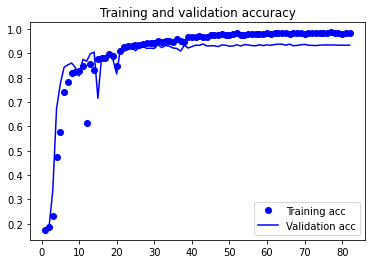

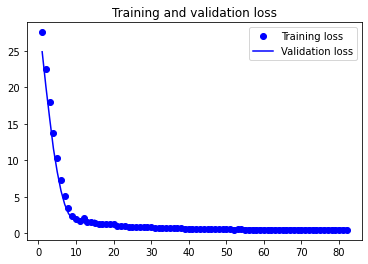

In [75]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [76]:
model.save('food_recognize_model13.h5')

In [77]:


test_datagen = ImageDataGenerator(rescale = 1./255,
                                 #以下4行做图像标准化
                                 featurewise_center=True, 
                                 featurewise_std_normalization=True,
                                 samplewise_center=True, 
                                 samplewise_std_normalization=True)
test_datagen.fit(X_test)


test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    target_size = (320,200),
                    batch_size =batchsize
                    )

Found 600 images belonging to 6 classes.


In [78]:
model.evaluate_generator(test_generator)

C:\Users\Nickelth\AppData\Local\Temp\ipykernel_26572\2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.7108152508735657, 0.9333333373069763]